In [1]:
import matplotlib.pyplot as plt
import numpy as np
from opensees import uniaxial
from opensees.units.english import ksi, psi, inch, ft

plt.style.use("berkeley")

In [2]:
Fy = 66.8*ksi          # STEEL yield stress
Es = 29000.*ksi        # modulus of steel
Bs = 0.005             # strain-hardening ratio 
R0 = 18                # control the transition from elastic to plastic branches
cR1 = 0.925            # control the transition from elastic to plastic branches
cR2 = 0.15             # control the transition from elastic to plastic branches

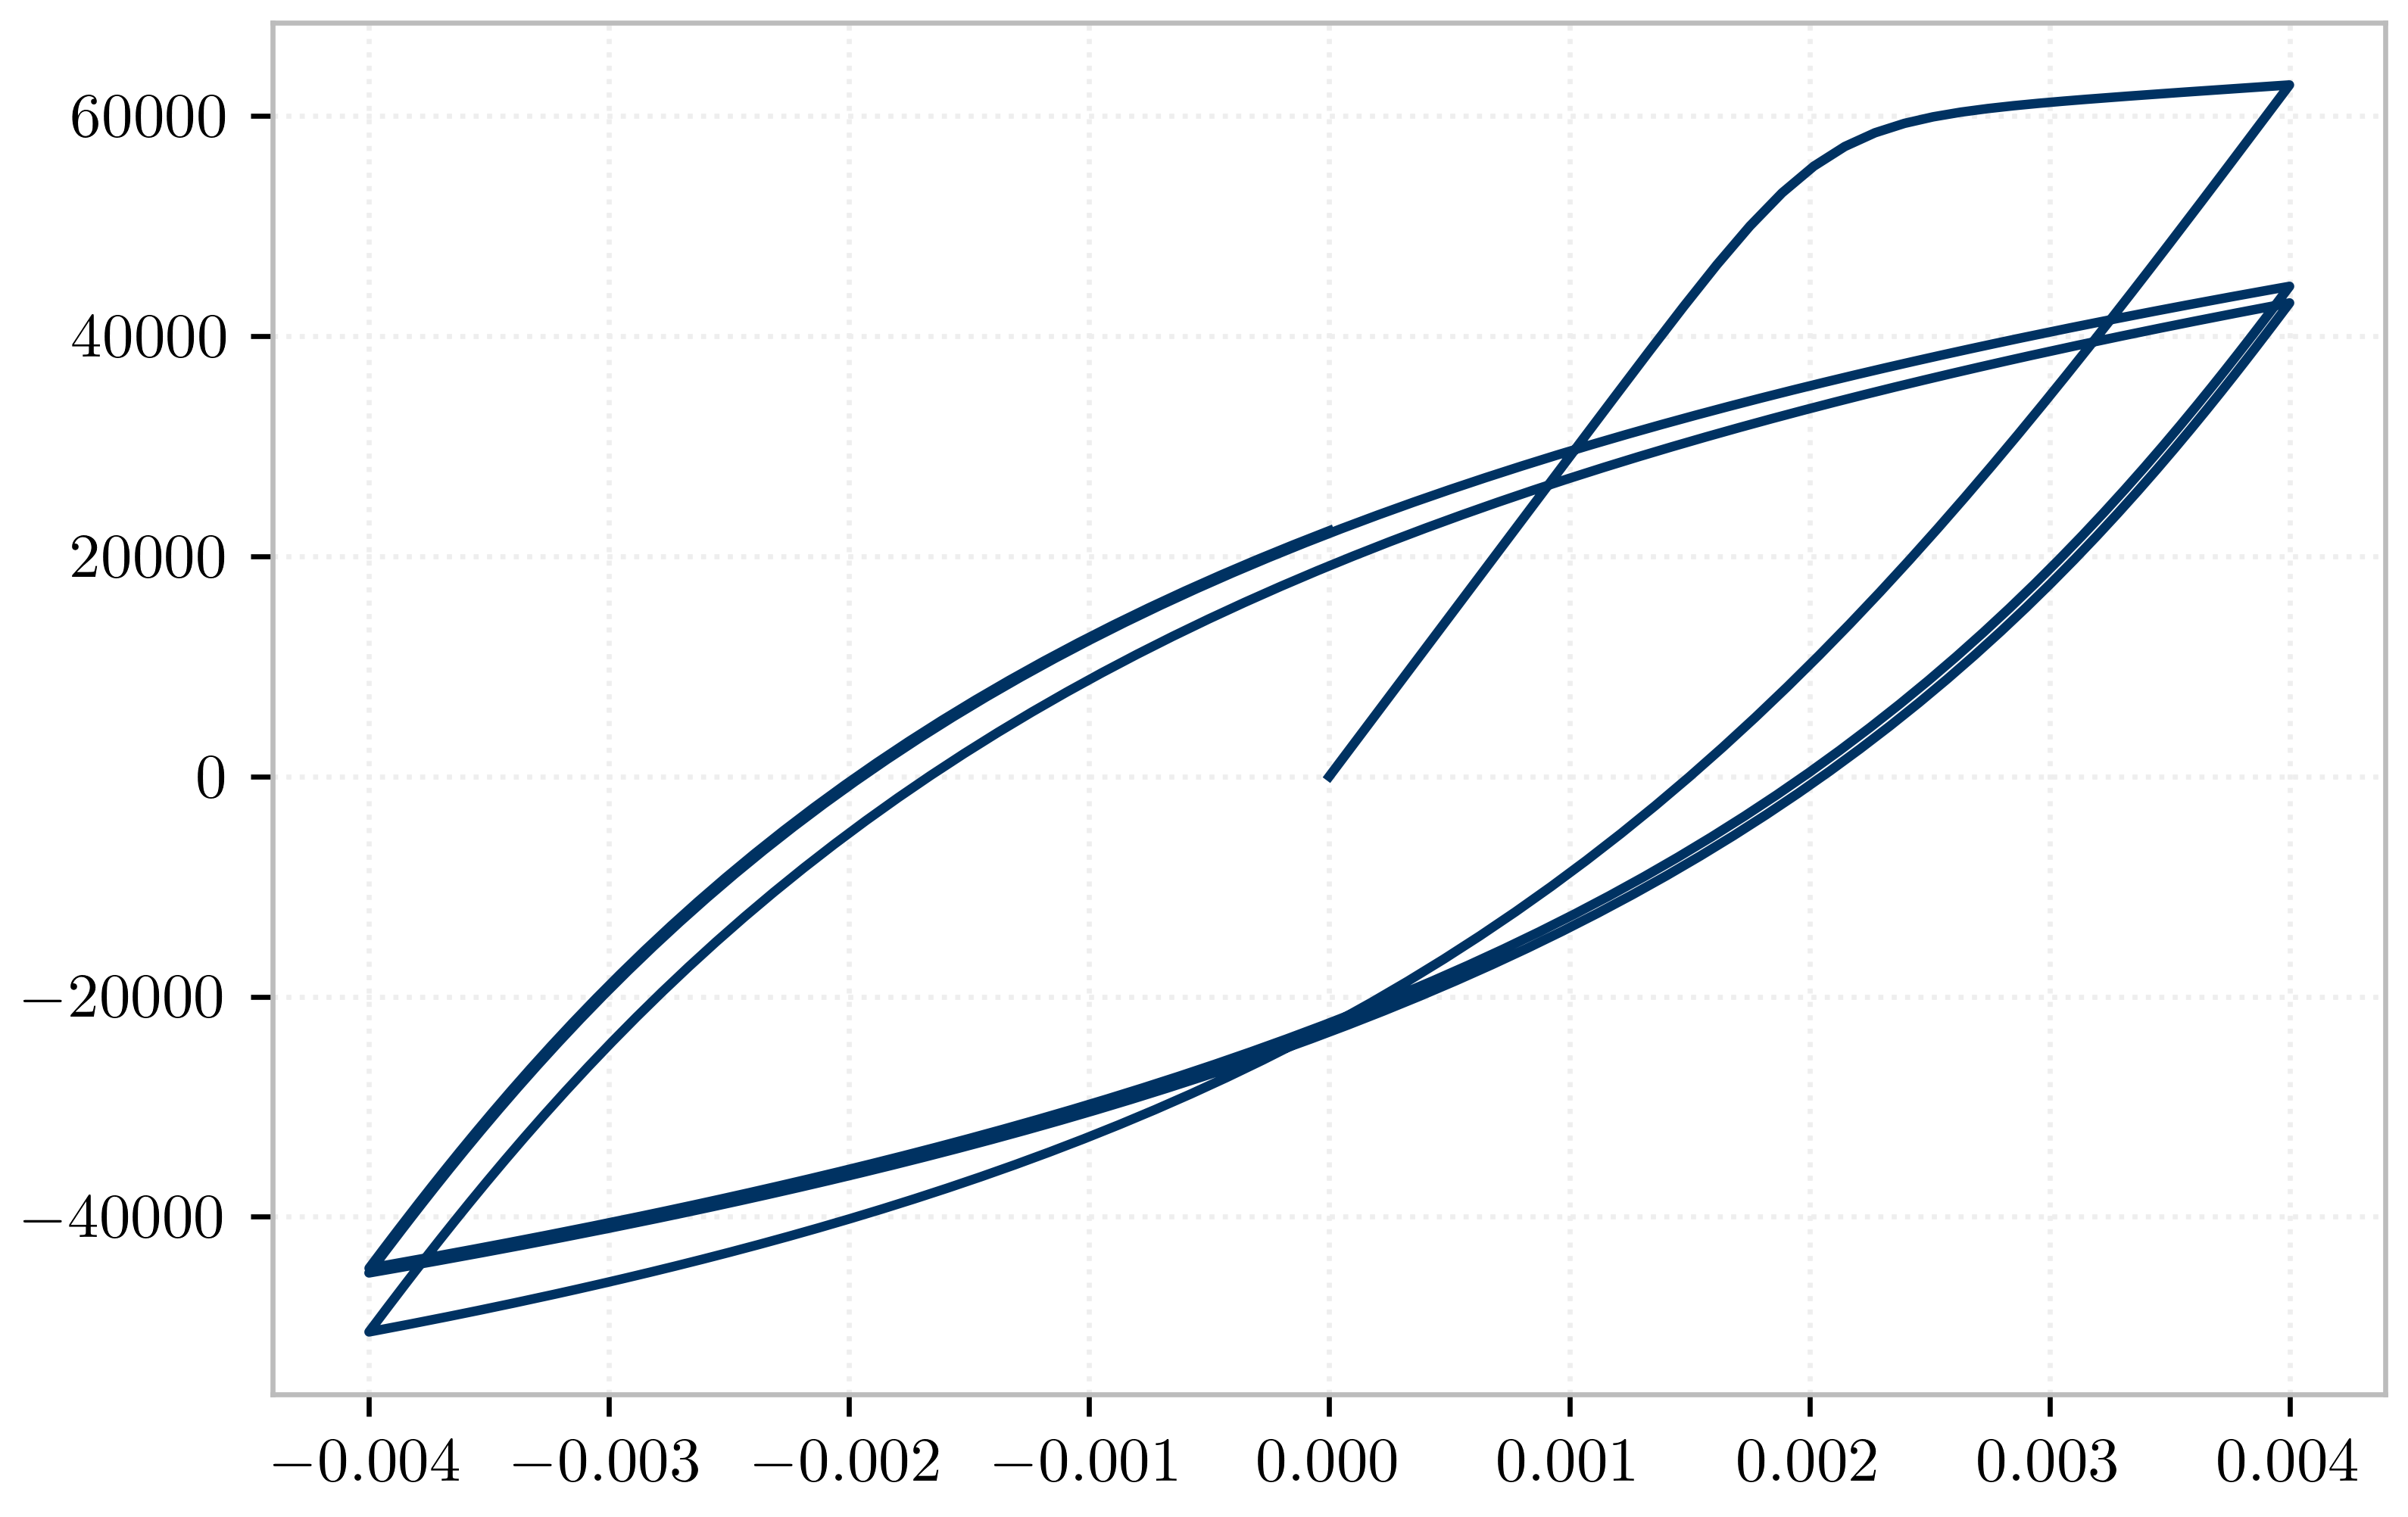

In [15]:
strain = 0.004*np.sin(np.linspace(0, 6*np.pi, 500))


with uniaxial.Steel02(1, 60e3, 29e6, 0.05, 10.) as steel:
    
    stress = [steel.getStress(e, commit=True) for e in strain]


plt.plot(strain, stress);

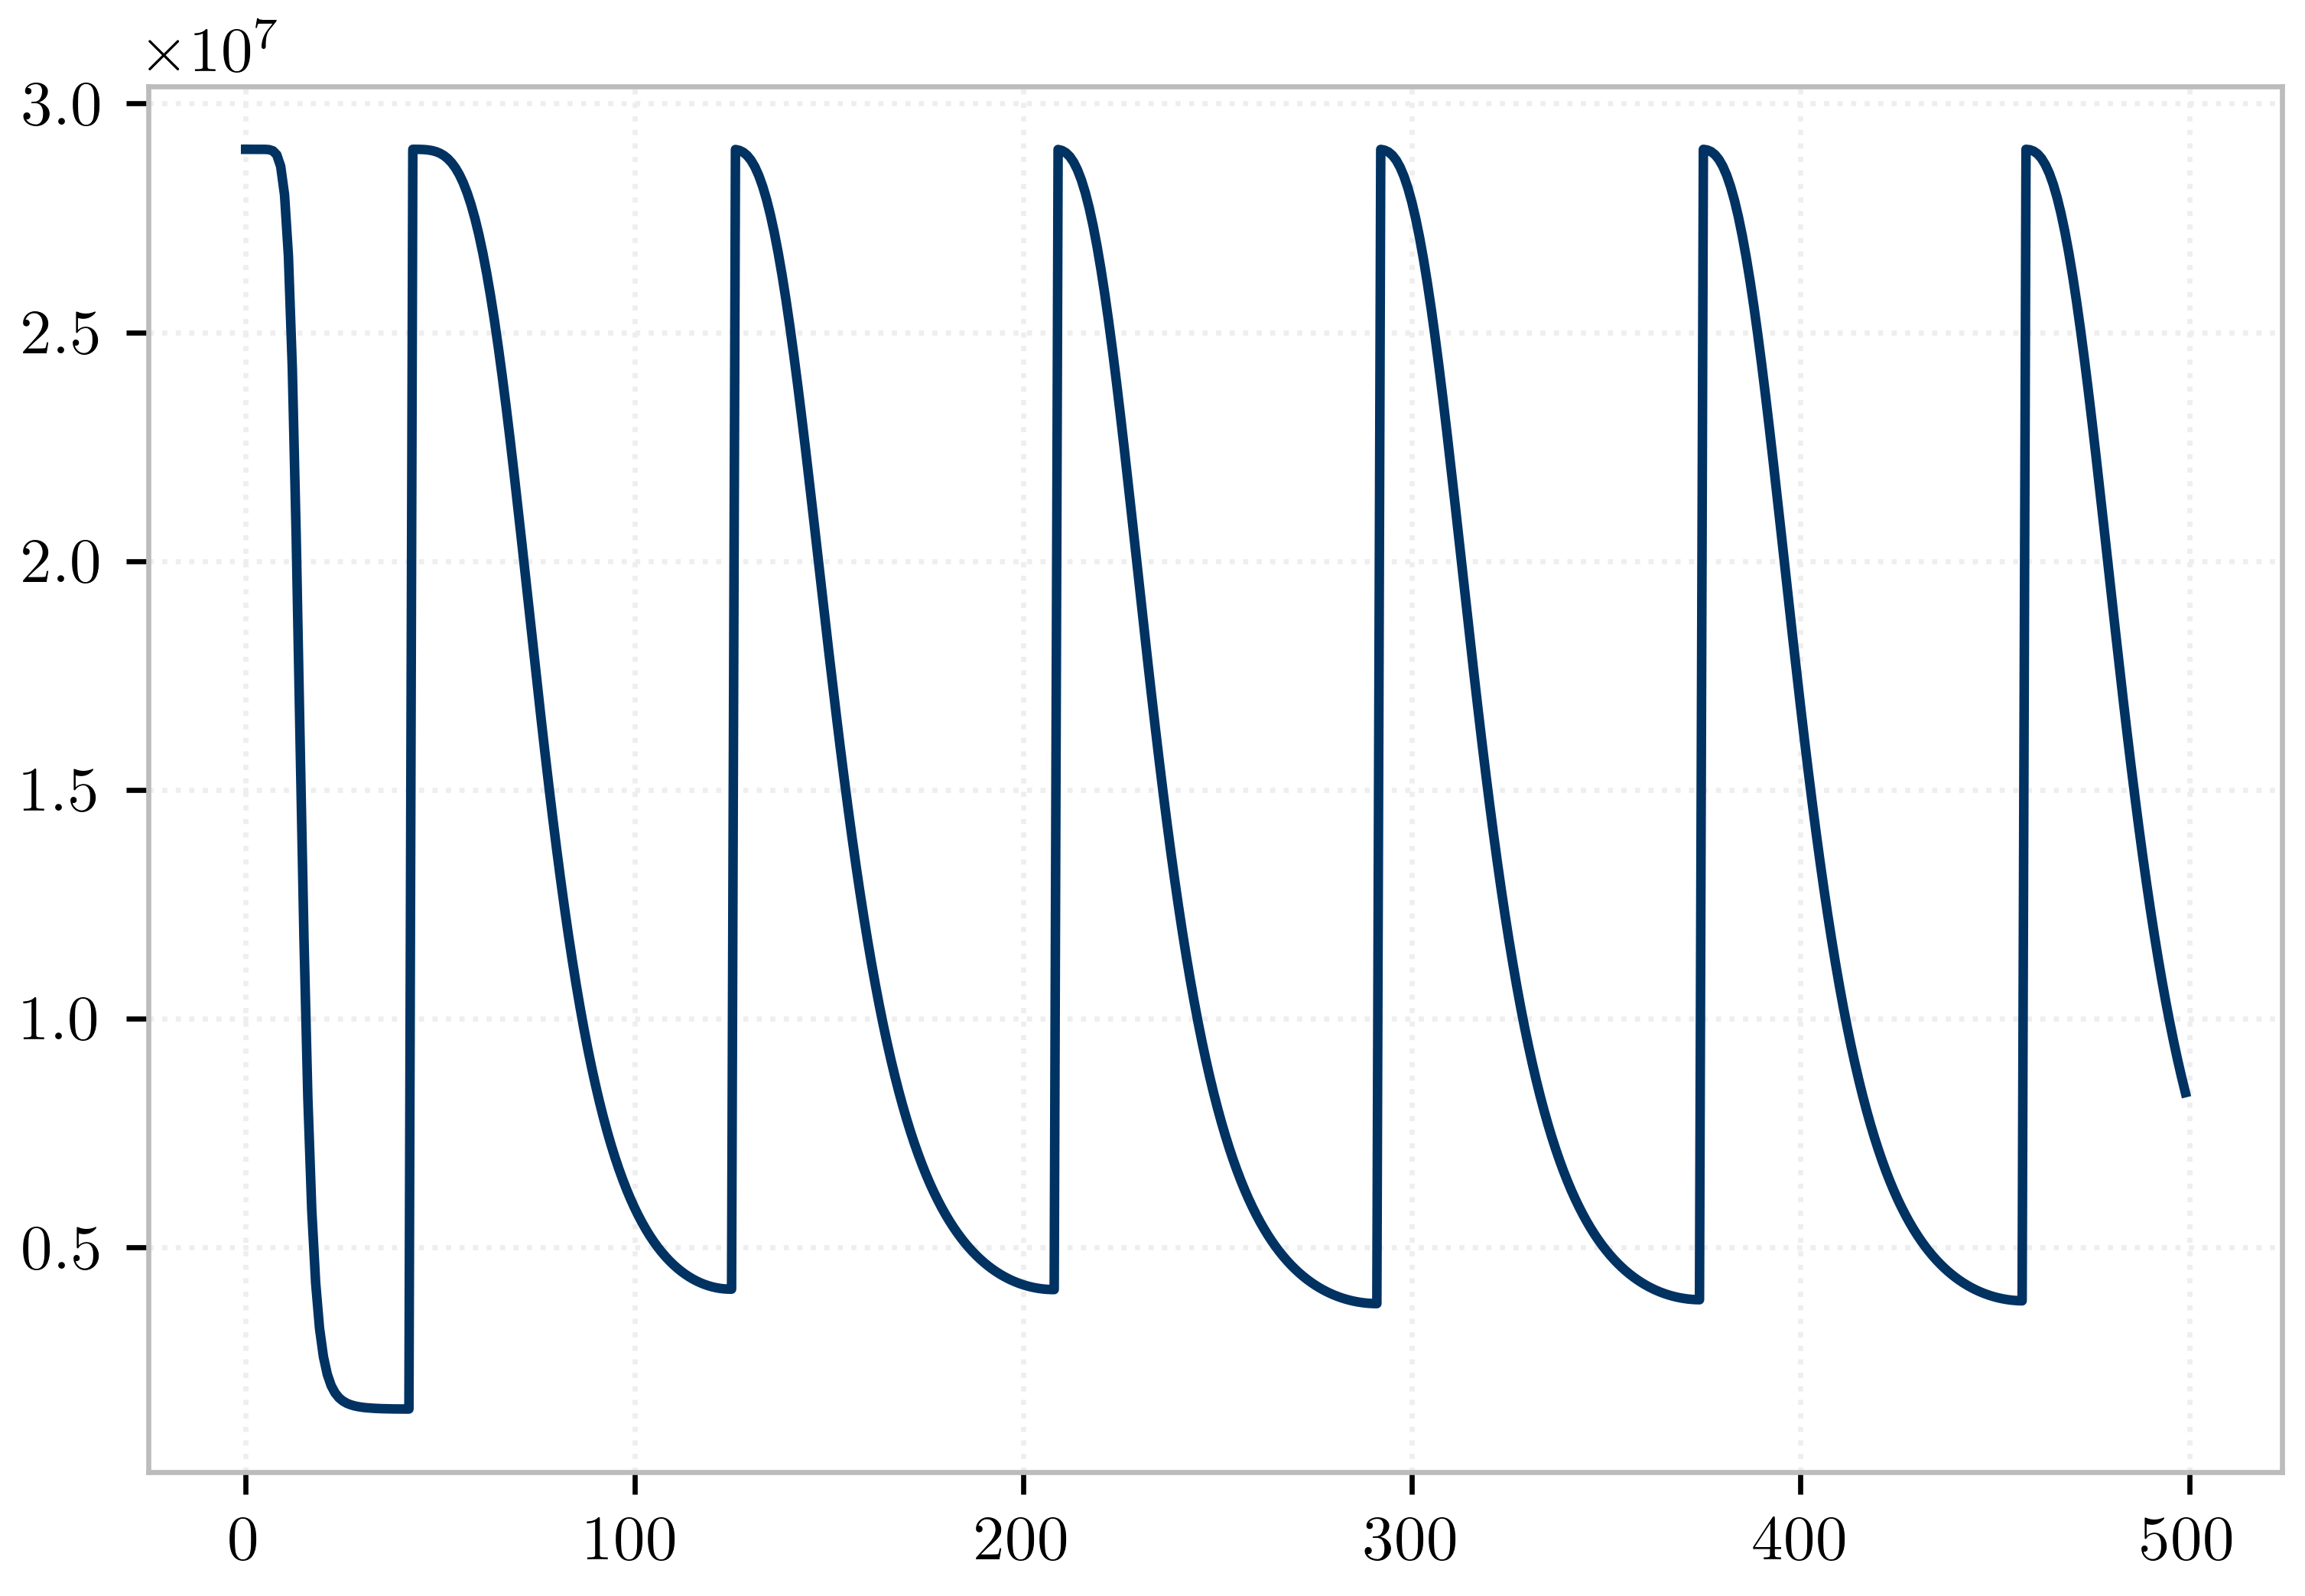

In [16]:
tangent = []

with uniaxial.Steel02(1, 60e3, 29e6, 0.05, 10.) as steel:
    for e in strain:
        steel.setTrialStrain(e)
        tangent.append(steel.getTangent())
        steel.commitState()

plt.plot(tangent);

In [5]:
from math import sqrt
# nominal concrete compressive strength
fc = -8.5*ksi              # CONCRETE Compressive Strength ksi   (+Tension -Compression)
Ec = 57*ksi*sqrt(-fc/psi)  # Concrete Elastic Modulus
# unconfined concrete
fc1U = fc                  # UNCONFINED concrete (todeschini parabolic model) maximum stress
eps1U = -0.003             # strain at maximum strength of unconfined concrete
fc2U = 0.2*fc1U            # ultimate stress
eps2U = -0.01              # strain at ultimate stress
_lambda = 0.1              # ratio between unloading slope at eps2 and initial slope Ec
# tensile-strength properties
ftU = -0.14*fc1U           # tensile strength +tension
Ets = ftU/0.002            # tension softening stiffness

In [6]:
concU = uniaxial.Concrete02(1, fc1U, eps1U, fc2U, eps2U, _lambda, ftU, Ets) # build cover, concrete (unconfined)
reinf = uniaxial.Steel02(None, Fy, Es, Bs, R0, cR1, cR2)                    # build 'reinforcement material

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\sigma$')

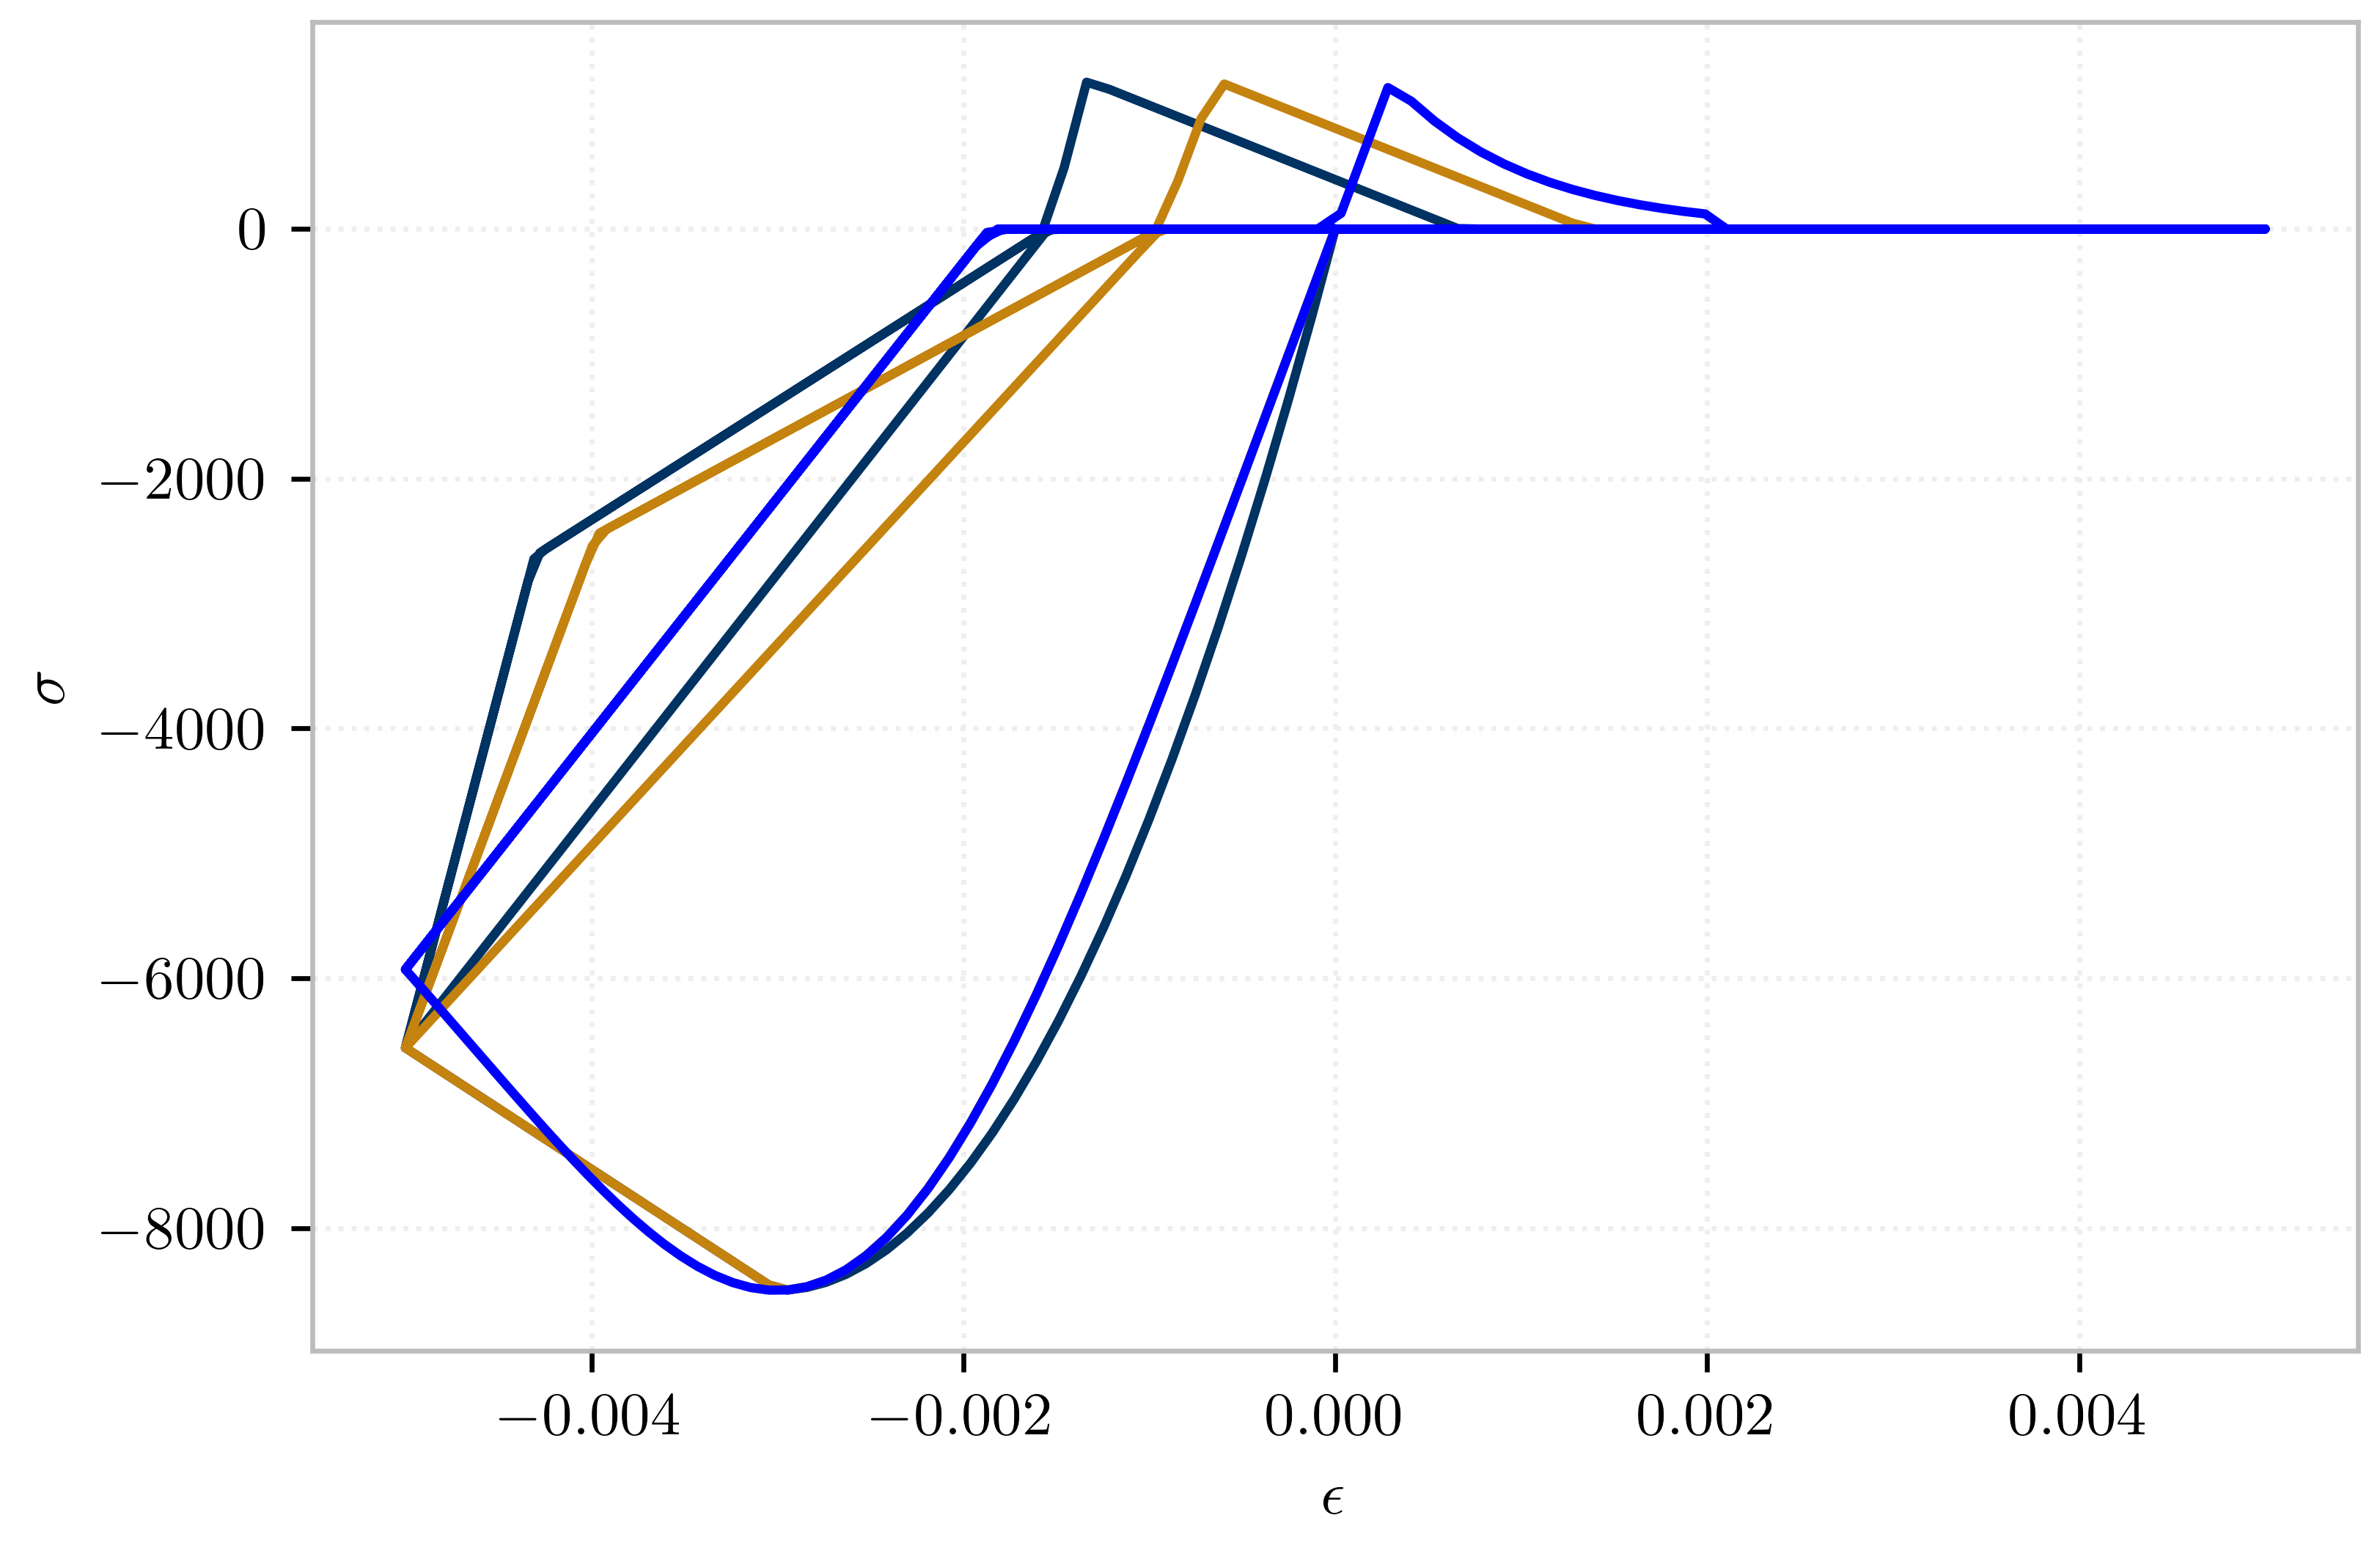

In [18]:
strain = -0.005*np.sin(np.linspace(0, 4*np.pi, 500))
fig, ax = plt.subplots()

with concU as c:
    stress = [c.getStress(e, commit=True) for e in strain]
    ax.plot(strain, stress)
    
with uniaxial.Concrete02IS(1, 4e3*ksi, fc1U, eps1U, fc2U, eps2U, [_lambda, ftU, Ets]) as conc:
    ax.plot(strain, [conc.getStress(e, commit=True) for e in strain])

with uniaxial.Concrete04(1, fc1U, eps1U, eps2U, 4e3*ksi, [ftU, ftU/Ets]) as conc:
    ax.plot(strain, [conc.getStress(e, commit=True) for e in strain])

    
ax.legend()
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\sigma$")
# with concU as c:
#     stress = []
#     for e in strain:
#         c.setTrialStrain(e)
#         stress.append(c.getStress())
#         c.commitState()
#     ax.plot(strain, stress, "x")
    

In [8]:
strain =  -np.linspace(0, 0.005, 100)

import pandas
ax = pandas.read_csv("stressStrain.csv", names=["strain", "stress"]).plot("strain", "stress", marker=".", label="test")

with uniaxial.Concrete02IS(1, 5e3*ksi, fc1U, eps1U, fc2U, eps2U, [_lambda, ftU, Ets]) as conc:
    ax.plot(-strain, [-conc.getStress(e, commit=True) for e in strain], label="Concrete02IS")

with concU as c:
    stress = [-c.getStress(e, commit=True) for e in strain]
    ax.plot(-strain, stress, label="Concrete02")

with uniaxial.Concrete04(1, fc1U, eps1U, eps2U, 4e3*ksi, [ftU, ftU/Ets]) as conc:
    ax.plot(-strain, [-conc.getStress(e, commit=True) for e in strain], label="Concrete04")

ax.legend()
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\sigma$");

FileNotFoundError: [Errno 2] No such file or directory: 'stressStrain.csv'